# Exploratory Data Analysis for Spotify Tracks

In [171]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## (Down)load data
We are using **Spotify Dataset 1921-2020, 600k+ Tracks** which is build from the Spotify API. Please download the [`tracks.csv` dataset from kaggle, 112 MB](https://www.kaggle.com/datasets/yamaerenay/spotify-dataset-19212020-600k-tracks?select=tracks.csv) and [`artist.csv` dataset from kaggle, 65 MB](https://www.kaggle.com/datasets/yamaerenay/spotify-dataset-19212020-600k-tracks?select=artists.csv)
... and put both in the `data` folder of the project repository. This notebook should be in the `notebooks` folder of the project repository.

In [172]:
tracks_df = pd.read_csv('../data/tracks.csv')
artists_df = pd.read_csv('../data/artists.csv')

tracks_df.shape, artists_df.shape

((586672, 20), (1162095, 5))

In [173]:
# merge tracks and artist dataframes to add the imortant 'artist_popularity' feature
tracks_df['id_artists'] = [i[2:-2] for i in tracks_df['id_artists']]
artists_df.rename(columns = {'id': 'id_artists','popularity': 'artists_popularity'}, inplace = True)
artists_df.drop(['genres', 'name'],axis = 1, inplace = True)
tracks_df = tracks_df.merge(artists_df, on = 'id_artists')
del artists_df

In [174]:
# convert release date to datetime
tracks_df['release_date'] = pd.to_datetime(tracks_df['release_date'], format = '%Y-%m-%d')
tracks_df['delta_days'] = tracks_df['release_date'].max() - tracks_df['release_date']
tracks_df['delta_days'] = tracks_df['delta_days'].view(dtype = int)

In [175]:
#exclude non-music content
tracks_df = tracks_df[tracks_df['speechiness']<0.66] #above 0.66 are tracks with only spoken words, not music

# drop select columns --> removing all object columns, removing all non-continous
tracks_df = tracks_df.drop(columns=["id", "name", "artists", "id_artists", 
                                    "release_date", "key", 
                                    "time_signature", "key"], axis=1)
tracks_df.dtypes

popularity              int64
duration_ms             int64
explicit                int64
danceability          float64
energy                float64
loudness              float64
mode                    int64
speechiness           float64
acousticness          float64
instrumentalness      float64
liveness              float64
valence               float64
tempo                 float64
followers             float64
artists_popularity      int64
delta_days              int64
dtype: object

In [176]:
tracks_df.head()

,popularity,duration_ms,explicit,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,followers,artists_popularity,delta_days
0,6,126903,0,0.645,0.44500,-13.338,1,0.4510,0.674,0.744,0.1510,0.127,104.851,91.0,4,3128803200000000000
1,0,157333,0,0.298,0.46000,-18.645,1,0.4530,0.521,0.856,0.4360,0.402,87.921,91.0,4,3128803200000000000
2,0,87040,0,0.634,0.00399,-29.973,0,0.0377,0.926,0.919,0.1050,0.396,79.895,91.0,4,3128803200000000000
3,0,40000,0,0.657,0.32500,-14.319,0,0.2540,0.199,0.856,0.0931,0.105,81.944,91.0,4,3128803200000000000
4,0,104400,0,0.644,0.68400,-8.247,1,0.1990,0.144,0.802,0.0847,0.138,100.031,91.0,4,3128803200000000000


In [177]:
# show correlation of popularity with other features in descending order
corr = tracks_df.corr()
corr['popularity'][np.absolute(corr['popularity'])>0.01].sort_values(ascending = False)

popularity            1.000000
artists_popularity    0.567611
loudness              0.281752
energy                0.261373
followers             0.231527
explicit              0.175030
danceability          0.142529
duration_ms           0.069867
tempo                 0.057545
speechiness           0.027401
mode                 -0.016540
liveness             -0.041517
valence              -0.042216
instrumentalness     -0.198077
acousticness         -0.336503
delta_days           -0.566481
Name: popularity, dtype: float64

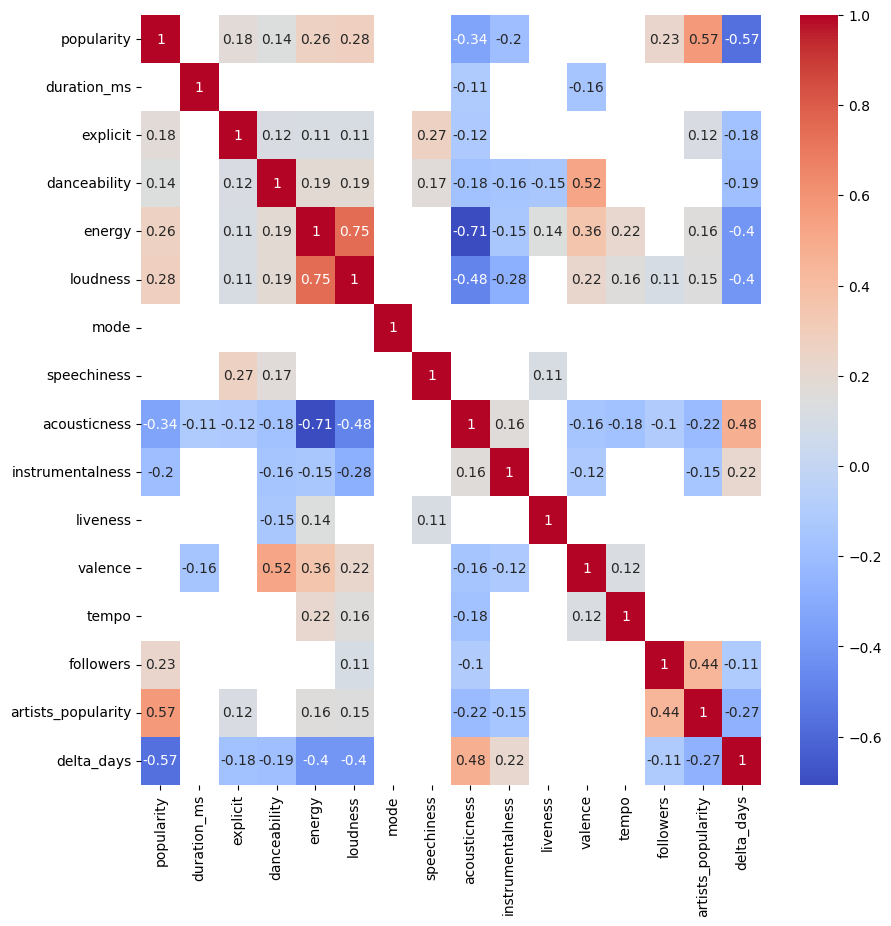

In [178]:
fig, ax = plt.subplots(figsize= (10,10))
sns.heatmap(corr[np.absolute(corr)>0.1], annot = True, cmap='coolwarm')
plt.show()

### Reduce size and memory usage of dataframe for training

In [179]:
# Randomly sample only 20% of the dataset ---> remove this for final training
tracks_min_df = tracks_df.sample(n=int(tracks_df.shape[0]/5))
tracks_df.shape, tracks_min_df.shape

((452017, 16), (90403, 16))

In [180]:
#Based on this great kernel https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65

def reduce_mem_usage(df):
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in df.columns:
        if df[col].dtype != object:  # Exclude strings              
            # make variables for Int, max and min
            IsInt = False
            mx = df[col].max()
            mn = df[col].min()
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(df[col]).all(): 
                NAlist.append(col)
                df[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = df[col].fillna(0).astype(np.int64)
            result = (df[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif mx < 65535:
                        df[col] = df[col].astype(np.uint16)
                    elif mx < 4294967295:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)    
            # Make float datatypes 32 bit
            else:
                df[col] = df[col].astype(np.float32)
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",round(100*mem_usg/start_mem_usg, 2),"% of the initial size")

In [181]:
X = tracks_df.drop(['popularity'], axis = 1)
y = tracks_df['popularity']

X_min = tracks_min_df.drop(['popularity'], axis = 1)
y_min = tracks_min_df['popularity']
reduce_mem_usage(X_min)

Memory usage of properties dataframe is : 11.0355224609375  MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  5.431546211242676  MB
This is  49.22 % of the initial size


# Part II: Grid Search parameters for XGBRegressor
on a smaller dataset `X_min`, `y_min`

In [182]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

### Preprocessing + Training Pipeline

## Grid Search using XGBoost Regressor on 10% of the data

In [183]:
xgb_reg = XGBRegressor()
parameters = {
    'random_state': [0],
    'reg_alpha': [0],
    'reg_lambda': [0.05],
    'gamma': [0, 0.2], #default: 0
    'n_estimators': [200, 350, 500],
    'learning_rate': [0.05], #default: 0.3
    'colsample_bytree': [0.5, 0.6, 0.7], #default: 1
    'subsample': [1], #default: 1
    'max_depth': [8], #default: 6
    'min_child_weight': [1], #default: 1
    'eval_metric': ['rmsle']
    }

clf = GridSearchCV(xgb_reg, parameters, n_jobs=-1)
clf.fit(X_min, y_min)
clf.best_params_, clf.best_score_

({'colsample_bytree': 0.5,
  'eval_metric': 'rmsle',
  'gamma': 0.2,
  'learning_rate': 0.05,
  'max_depth': 8,
  'min_child_weight': 1,
  'n_estimators': 500,
  'random_state': 0,
  'reg_alpha': 0,
  'reg_lambda': 0.05,
  'subsample': 1},
 0.6335704834002778)

## The actual training
on the full dataset, using the parameters found above

In [184]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [185]:
# initialize new XGBRegressor with best parameters from grid search on small dataset
xgb_reg = clf.best_estimator_

# fit on the full dataset
xgb_reg.fit(X_train, y_train, verbose=False)

# Predict against the test set
xgb_pred = xgb_reg.predict(X_test)
    
# Score    
rmse_xgb = mean_squared_error(y_test, xgb_pred, squared=False)
print("Root Mean Squared Error for XGBoost Regressor:", round(rmse_xgb, 3))
r2_xgb = r2_score(y_test, xgb_pred)
print("R2 Score for XGBoost Regressor:", round(r2_xgb, 3))

Root Mean Squared Error for XGBoost Regressor: 10.202
R2 Score for XGBoost Regressor: 0.665
